# Partie 1 : Inversion de fonction par réseau de neurones

2025-03-06 12:32:05.606997: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/200


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5283
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2284
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1148
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0804
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0494 
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0341
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0271
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0189
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0165
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0141
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0128
Epoch 12/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0119 
Epoch 13/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0125 
Epoch 14/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0121
Epoch 15/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0124
Epoch 16/200


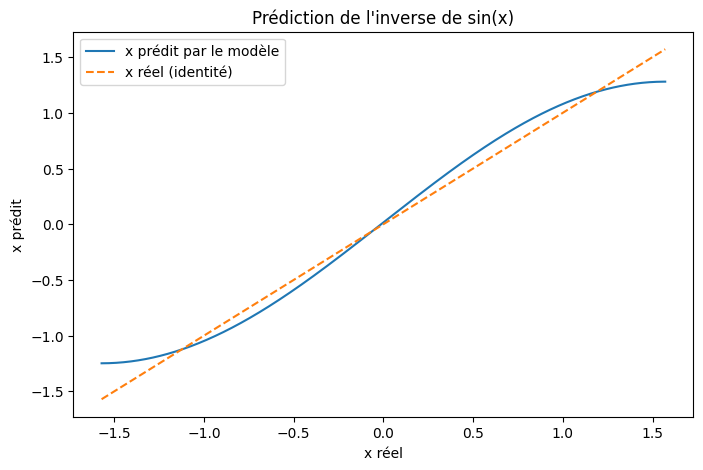

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# 1. Générer le jeu de données
# Pour un bon apprentissage, prenons x dans [-pi/2, pi/2]
x_true = np.linspace(-np.pi/2, np.pi/2, 1000)  # x réel, valeurs en radians
y = np.sin(x_true)  # y correspond à sin(x)

# 2. Définir le modèle
model = Sequential([
    Dense(3, input_dim=1, activation='relu'),
    Dense(3, activation='relu'),
    Dense(1, activation='linear')
])
model.compile(optimizer=Adam(0.01), loss='mse')

# 3. Entraînement
# On utilise y comme entrée et x_true comme cible, pour approximer arcsin
history = model.fit(y, x_true, epochs=200, verbose=1)

# 4. Évaluation et visualisation
x_pred = model.predict(y)
plt.figure(figsize=(8, 5))
plt.plot(x_true, x_pred, label='x prédit par le modèle')
plt.plot(x_true, x_true, label='x réel (identité)', linestyle='dashed')
plt.xlabel('x réel')
plt.ylabel('x prédit')
plt.title("Prédiction de l'inverse de sin(x)")
plt.legend()
plt.show()

# Partie 2 : Modèles de diffusion sur images

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Exemple d'un U-Net simplifié pour la prédiction du bruit
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        # Ici, vous définissez vos couches d'encodage et décodage
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=3, padding=1)
        )
    
    def forward(self, x):
        x_enc = self.encoder(x)
        x_dec = self.decoder(x_enc)
        return x_dec

# Préparer le dataset (ici MNIST)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)

# Définir le modèle, la fonction de perte et l'optimiseur
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleUNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Définir un noise schedule simple (exemple)
def add_noise(images, t, max_noise=0.5):
    noise_level = t / 100.0 * max_noise
    noise = torch.randn_like(images) * noise_level
    return images + noise, noise

# Entraînement du modèle
num_epochs = 5  # Pour un test, augmenter pour de meilleurs résultats
for epoch in range(num_epochs):
    for images, _ in train_loader:
        images = images.to(device)
        # Choisir une étape t aléatoire pour chaque batch
        t = torch.randint(0, 100, (images.size(0),)).to(device).float()
        noisy_images, noise = add_noise(images, t)
        
        optimizer.zero_grad()
        noise_pred = model(noisy_images)
        loss = criterion(noise_pred, noise)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

# Pour l'inférence, on démarre avec du bruit et on itère le débruitage
def denoise(model, steps=100, image_size=(1, 28, 28), device='cpu'):
    model.eval()
    with torch.no_grad():
        # Démarrer avec du bruit pur
        current = torch.randn(1, *image_size).to(device)
        for t in range(steps):
            # Ici, le modèle prédit le bruit à retirer
            noise_pred = model(current)
            # Une simple règle de mise à jour (pour illustrer, à raffiner)
            current = current - noise_pred / steps
        return current

generated_image = denoise(model, steps=100, image_size=(1,28,28), device=device)
# Visualisation (en utilisant matplotlib)
import matplotlib.pyplot as plt
plt.imshow(generated_image.squeeze().cpu().numpy(), cmap='gray')
plt.title("Image générée par le modèle de diffusion")
plt.show()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:00<00:00, 18308193.85it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 346740.98it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:00<00:00, 3817764.25it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 2456547.87it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



RuntimeError: The size of tensor a (28) must match the size of tensor b (64) at non-singleton dimension 3